Pipeline for making train and test out of large images

In [1]:
%load_ext autoreload

In [2]:
# merge the inputs
%autoreload
import sys
import os
sys.path.append("..")

from costum_arild.source import data_processing
from costum_arild.source.data_processing import TrainingImage
from costum_arild.source.utils import image_processing_utils

In [3]:
import numpy as np
import gdal
import json
import glob
import os
import sys
from osgeo import ogr
from osgeo import osr
import copy
import random
import pandas as pd
import shutil

first lets just try to see how it works

In [4]:
# make a list of files we want to split
image_list = ['/home/saeid/phd/segmentation/dataset/large images/image_labeled/gaula_1963/33-2-462-207-23.tif']
label_list = ['/home/saeid/phd/segmentation/dataset/large images/rasters/gaula_1963/label33-2-462-207-23.tif']
output_directory = '/home/saeid/phd/segmentation/dataset/large images/test_small_images'

applying other methods to large images is time consuming. so we can apply them to small images. so we need to rewrite the devide image function and add 3 channel as well

In [4]:
def divide_image_add_channel(image_filepath, label_filepath, image_size=512, do_overlap=False, do_crop=False, add_filter_channel=False):
    
    """
    add_filter_channel: indicate if we want to have filters as external channels
    """
    
    # Load image
    image_ds = gdal.Open(image_filepath)
    geo_transform = image_ds.GetGeoTransform()
    projection = image_ds.GetProjection()
    # check the number of rasters
    image_matrix = np.array(([image_ds.GetRasterBand(band_idx+1).ReadAsArray() for band_idx in range(image_ds.RasterCount)]))
    if len(image_matrix.shape) > 2:
        # get (x,y, channel) form
        image_matrix = np.transpose(image_matrix, axes=[1, 2, 0])
    
    # this part is different since we want to have Gray scale
    from PIL import Image
    image_matrix = np.array(Image.fromarray(image_matrix).convert('L'))
    image_ds = None
    

    # Load label
    label_ds = gdal.Open(label_filepath)
    if label_ds.GetGeoTransform() != geo_transform:
        raise Exception(f"The geo transforms of image {image_filepath} and label {label_filepath} did not match")
    label_matrix = label_ds.GetRasterBand(1).ReadAsArray()
    label_ds = None

    training_data = []
    # Make properly sized training data
    # Make sure that the whole image is covered, even if the last one has to overlap
    if do_overlap:
        shape_0_indices = list(range(image_size // 4, image_matrix.shape[0], image_size // 4))[:-4]
        shape_1_indices = list(range(image_size // 4, image_matrix.shape[1], image_size // 4))[:-4]
    else:
        shape_0_indices = list(range(0, image_matrix.shape[0], image_size))
        shape_0_indices[-1] = image_matrix.shape[0] - image_size
        shape_1_indices = list(range(0, image_matrix.shape[1], image_size))
        shape_1_indices[-1] = image_matrix.shape[1] - image_size
    # Split the images
    for shape_0 in shape_0_indices:
        for shape_1 in shape_1_indices:
            if do_crop:
                # Extract labels for the center of the image
                labels = label_matrix[shape_0 + image_size // 4:shape_0 + image_size - image_size // 4,
                         shape_1 + image_size // 4:shape_1 + image_size - image_size // 4]
            else:
                labels = label_matrix[shape_0:shape_0 + image_size, shape_1:shape_1 + image_size]
            # Check if the image has to much unknown
            if not data_processing.is_quality_image(labels):
                continue

            # Calculate the geo transform of the label
            label_geo_transform = list(geo_transform)
            if do_crop:
                label_geo_transform[0] += (shape_1 + image_size//4) * geo_transform[1]  # East
                label_geo_transform[3] += (shape_0 + image_size//4) * geo_transform[5]  # North
            else:
                label_geo_transform[0] += (shape_1) * geo_transform[1]  # East
                label_geo_transform[3] += (shape_0) * geo_transform[5]  # North

            data = image_matrix[shape_0:shape_0 + image_size, shape_1:shape_1 + image_size]
            filter_channel = image_processing_utils.qshitf_boundary(data, ratio=0.9)
            cluster_channel = image_processing_utils.laplacian_filter(data, sigma=5)
            
            data_3d = np.stack([data, filter_channel, cluster_channel], axis=-1)
            
            new_data_geo_transform = list(geo_transform)
            new_data_geo_transform[0] += shape_1 * geo_transform[1]  # East
            new_data_geo_transform[3] += shape_0 * geo_transform[5]  # North

            name = os.path.split(image_filepath)[-1].replace(".tif", "") + f"_n_{shape_0}_e_{shape_1}"
            training_data.append(TrainingImage(data_3d, labels, new_data_geo_transform, name=name, projection=projection,
                                               label_geo_transform=label_geo_transform, east_offset=shape_1,
                                               north_offset=shape_0))
    return training_data

In [5]:
def divide_and_save_channeled_images(image_filepaths, label_filepaths, output_folder=None, image_size=512,
                           do_overlap=False, do_crop=False):
    """
    This function takes big images and splits them into smaller images and saves them to disk
    :param image_filepaths: A list of filepaths to the images that will be loaded
    :param label_filepaths: A list of filepaths to the label (rasters) that will be loaded
    :param output_folder: The folder where the new rasters will be saved. If it is None, the files will not be saved
    :param image_size: The size of the new images, measured in pixels
    :return: list of TrainingImage objects
    """

    # Check that the size of the filepaths are the same are loaded
    if len(image_filepaths) != len(label_filepaths):
        raise Exception(f"The image filepaths and label filepaths must be in sync,"
                        f" but their lengths did not match. {len(image_filepaths)} != {len(label_filepaths)}")
    # Load the images
    # Write the images to disk
    if output_folder is not None:
        # Make output folders
        os.makedirs(os.path.join(output_folder, "images"), exist_ok=True)
        os.makedirs(os.path.join(output_folder, "labels"), exist_ok=True)
        for i in range(len(image_filepaths)):
            training_images = divide_image_add_channel(image_filepaths[i], label_filepaths[i], image_size=image_size,
                                           do_overlap=do_overlap, do_crop=do_crop)
            for image in training_images:
                # Data
                data_path = os.path.join(output_folder, "images", image.name + ".tif")
                image.write_data_to_raster(data_path)
                # Labels
                label_path = os.path.join(output_folder, "labels", image.name + ".tif")
                image.write_labels_to_raster(label_path)


In [6]:
divide_and_save_channeled_images(image_filepaths=image_list, 
                                 label_filepaths=label_list,
                                 output_folder=output_directory)

In [20]:
# adding channel to small images

In [33]:
# read the images
%autoreload
from costum_arild.source.utils import model_utils

In [34]:
image_directory = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset/train/images'
label_directory = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset/train/labels'


image_file_list = glob.glob(os.path.join(image_directory, "*.tif"))
label_file_list = glob.glob(os.path.join(label_directory, "*.tif"))

In [35]:
def add_extra_channel_save(image_file_list, output_directory):
    """
    This function adds two channels to the images and save them with the same name at output_directory
    """
    output_image_directory = os.path.join(output_directory, 'image_3channel')

    os.makedirs(output_image_directory, exist_ok=True)

    for idx, _ in enumerate(image_file_list):
        # Check if the image and label have the same name
        image_name = os.path.split(image_file_list[idx])[-1]
        if os.path.split(label_file_list[idx])[-1].replace("label", "") != image_name:
            raise ValueError(f'name of {os.path.split(label_file_list[idx])[-1]} and {os.path.split(image_file_list[idx])[-1]} are not the same.')

        # Get all the channels
        image_object = model_utils.load_data(image_file_list[idx], label_file_list[idx])
        filter_channel = image_processing_utils.qshitf_boundary(data, ratio=0.9)
        cluster_channel = image_processing_utils.laplacian_filter(data, sigma=5)
        data_channel = image_object.data

        # Add channels as data for image object
        image_object.data = np.stack([data_channel, cluster_channel, filter_channel], -1)
        image_object.write_data_to_raster(os.path.join(output_image_directory, image_name))
        print(f'made image {idx}')

In [36]:
output_path = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/'

add_extra_channel_save(image_file_list=image_file_list, output_directory=output_path)

ModuleNotFoundError: No module named 'data_processing'

# Tensorflow data 

In [4]:
# check the datadrive
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_device, True)
        print('\nSet memory growth to True\n')
    except:
        print('\nDid not set growth rate\n')

2021-11-07 19:02:10.325200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1



Set memory growth to True



2021-11-07 19:02:10.982094: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-07 19:02:10.986576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-07 19:02:11.102702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 19:02:11.103217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Super with Max-Q Design computeCapability: 7.5
coreClock: 1.08GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-11-07 19:02:11.103280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-07 19:02:11.127023: I tensorflow/stream_exec

In [91]:
# Setup data generators
train_data_folder_path = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/train'
train_image_directory_name = 'image_png3d'
train_label_directory_name = 'labels_png3d'
batch_size = 4

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                        preprocessing_function=lambda x: x/(2**8 -1)
)

mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

image_generator = image_datagen.flow_from_directory(os.path.join(train_data_folder_path, train_image_directory_name),
                        class_mode=None, target_size=(512, 512), seed=1, batch_size=batch_size)

mask_generator = mask_datagen.flow_from_directory(os.path.join(train_data_folder_path, train_label_directory_name),
                                                  class_mode=None, target_size=(512, 512), seed=1, batch_size=batch_size,
                                                  color_mode="grayscale")

train_generator = (pair for pair in zip(image_generator, mask_generator))


Found 38432 images belonging to 1 classes.
Found 38432 images belonging to 1 classes.


In [92]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


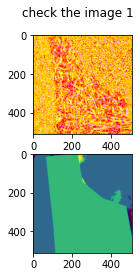

In [93]:
tmp_img_instance, tmp_mask_instance = next(train_generator)
fig, axs = plt.subplots(2)
fig.suptitle('check the image 1')
axs[0].imshow(tmp_img_instance[0])
axs[1].imshow(tmp_mask_instance[0].squeeze())
plt.show()

In [94]:
tmp_img_instance[1][:,:,0].max(), tmp_img_instance[1][:,:,1].max(), tmp_img_instance[1][:,:,2].max()

(254.0, 255.0, 1.0)

In [134]:
train_data_folder_path = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/val'
train_image_directory_name = 'image_png3d'
train_label_directory_name = 'labels_png3d'

# val_x_direct = glob.glob(os.path.join(train_data_folder_path, 
#                                       train_image_directory_name,
#                                       "img/*.png"))


In [149]:
from imageio import imread

def load_png_to_np_normalized(img_path, image_name, normalized=False):
    from imageio import imread
    """
    return: A numpy array with shape (n, image_size, image_size, 3)
    """
    val_x_direct = glob.glob(os.path.join(img_path, 
                                      image_name,
                                      "img/*.png"))
    if normalized:
        image_np = np.stack([imread(img_path)/ 255.0 for img_path in val_x_direct], axis=0)
    else:
        image_np = np.stack([imread(img_path) for img_path in val_x_direct], axis=0)
    if image_np.ndim < 4:
        image_np= np.expand_dims(image_np, axis=-1)
        
    return image_np

In [150]:
tmp_np = load_png_to_np_normalized(img_path=train_data_folder_path, 
                     image_name=train_image_directory_name, normalized=True)

In [151]:
tmp_lbl = load_png_to_np_normalized(img_path=train_data_folder_path, 
                     image_name=train_label_directory_name)

In [152]:
tmp_lbl.shape, tmp_np.shape

((118, 512, 512, 1), (1210, 512, 512, 3))

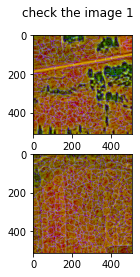

In [129]:
tmp_img_instance, tmp_mask_instance = next(train_generator)
fig, axs = plt.subplots(2)
fig.suptitle('check the image 1')
axs[0].imshow(tmp_np[0])
axs[1].imshow(tmp_np[1])
plt.show()

In [111]:
tmp_np[0][:,:,0].max()

0.8392156862745098

## change channels

In [95]:
from PIL import Image
def change_superpixel_edge_value(src_img_path, dst_img_path):
    
    val_x_direct = glob.glob(os.path.join(src_img_path,
                                          "img/*.png"))
    os.makedirs(dst_img_path, exist_ok=True)
    
    for idx, img_path in enumerate(val_x_direct):
#         print(f'image {idx}')
        img_matrix = imread(img_path)
        img_matrix[:,:,2] = img_matrix[:,:,2]*255.0
        
        img_name = os.path.split(img_path)[-1]
        save_path = os.path.join(dst_img_path, img_name)
        
        # save the image
        im = Image.fromarray(img_matrix)
        im.save(save_path)

In [96]:
src_data_folder_path = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/train/image_png3d'
dst_data_folder_path = '/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/train/image_png3d_new/img'

change_superpixel_edge_value(src_img_path=src_data_folder_path,
                             dst_img_path=dst_data_folder_path)

In [73]:
change_superpixel_edge_value(src_img_path=os.path.join(train_data_folder_path, train_image_directory_name),
                             dst_img_path='/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/val')

/home/saeid/phd/segmentation/dataset/machine_learning_dataset_3channel/val1/33-2-454-210-30_n_1536_e_4608.png


In [59]:
img_list_tmp = load_png_np(
    img_path=train_data_folder_path, 
    image_name=train_image_directory_name)

In [69]:
len(img_list_tmp), img_list_tmp[2][:,:,2]*255.0

(1210,
 Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))